# FaceMask Detection

In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.image import imread
import matplotlib.patches as patches
from PIL import Image

In [8]:
os.makedirs('FaceMaskDataSet', exist_ok=True)

The dataset used for this project can be found on [Kaggle](https://www.kaggle.com/datasets/omkargurav/face-mask-dataset). Please download the ZIP file and place it in the `FaceMaskDataSet` directory. Once downloaded, extract the contents using the Python `extractall()` method from the `zipfile` library, as demonstrated below:

In [5]:
import zipfile

zip_path = os.path.join('FaceMaskDataSet', 'archive.zip')
dataset_path = os.path.join('FaceMaskDataSet')

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(dataset_path)

In [9]:
data_dir = os.path.join('FaceMaskDataSet', 'data')
with_mask_dir = os.path.join(data_dir, 'with_mask')
without_mask_dir = os.path.join(data_dir, 'without_mask')

def create_mask_dataframe(with_mask_dir, without_mask_dir):
    data = {'filename': [], 'label': []}

    for filename in os.listdir(with_mask_dir):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            data['filename'].append(os.path.join(with_mask_dir, filename))
            data['label'].append('0')

    for filename in os.listdir(without_mask_dir):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            data['filename'].append(os.path.join(without_mask_dir, filename))
            data['label'].append('1')
    
    return pd.DataFrame(data)

df = create_mask_dataframe(with_mask_dir, without_mask_dir)

In [10]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, shuffle=True)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, shuffle=False)

print(f"Train set: {len(train_df)} images")
print(f"Validation set: {len(val_df)} images")
print(f"Test set: {len(test_df)} images")


Train set: 5287 images
Validation set: 1133 images
Test set: 1133 images


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='label',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filename',
    y_col='label',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',
    y_col='label',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 5287 validated image filenames belonging to 2 classes.
Found 1133 validated image filenames belonging to 2 classes.
Found 1133 validated image filenames belonging to 2 classes.


In [9]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

In [16]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [10]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [11]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [12]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/20


c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


166/166 [==============================] - 224s 1s/step - loss: 0.4014 - accuracy: 0.8205 - val_loss: 0.2091 - val_accuracy: 0.9126
Epoch 2/20
166/166 [==============================] - 224s 1s/step - loss: 0.2689 - accuracy: 0.8884 - val_loss: 0.1586 - val_accuracy: 0.9435
Epoch 3/20
166/166 [==============================] - 221s 1s/step - loss: 0.2373 - accuracy: 0.9043 - val_loss: 0.1325 - val_accuracy: 0.9532
Epoch 4/20
166/166 [==============================] - 222s 1s/step - loss: 0.2184 - accuracy: 0.9105 - val_loss: 0.1297 - val_accuracy: 0.9550
Epoch 5/20
166/166 [==============================] - 226s 1s/step - loss: 0.2091 - accuracy: 0.9151 - val_loss: 0.1197 - val_accuracy: 0.9576
Epoch 6/20
166/166 [==============================] - 223s 1s/step - loss: 0.1978 - accuracy: 0.9187 - val_loss: 0.1136 - val_accuracy: 0.9612
Epoch 7/20
166/166 [==============================] - 222s 1s/step - loss: 0.1895 - accuracy: 0.9260 - val_loss: 0.1120 - val_accuracy: 0.9603
Epoch 8/20

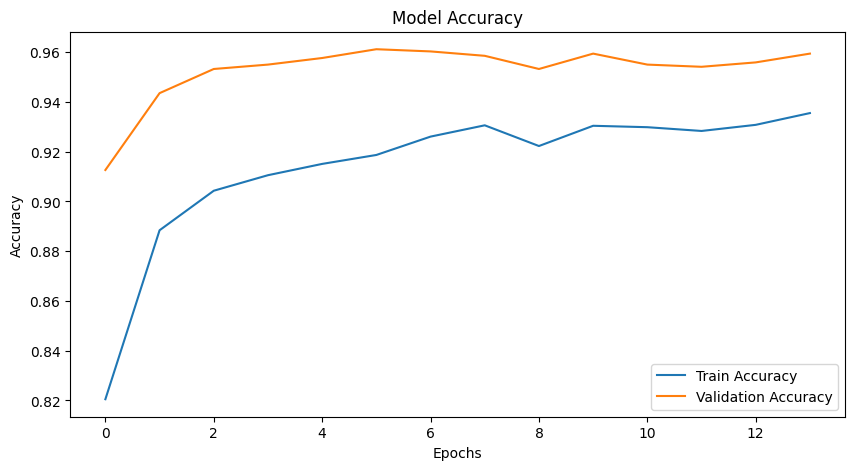

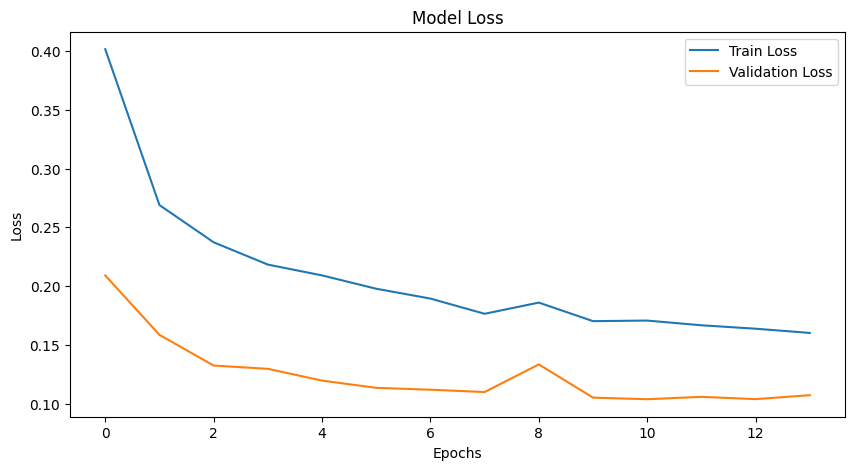

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
model.save('mask_detector_model.h5')

## Testing

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from tensorflow.keras.models import load_model

model = load_model('mask_detector_model.h5')

y_pred = model.predict(test_generator)
y_pred_classes = (y_pred >= 0.5).astype(int)

y_true = test_generator.classes


36/36 [==============================] - 52s 1s/step


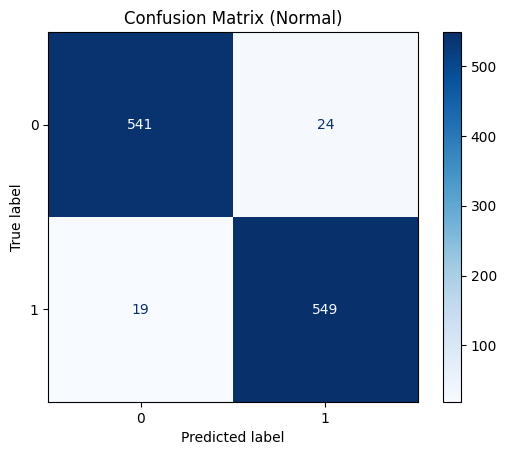

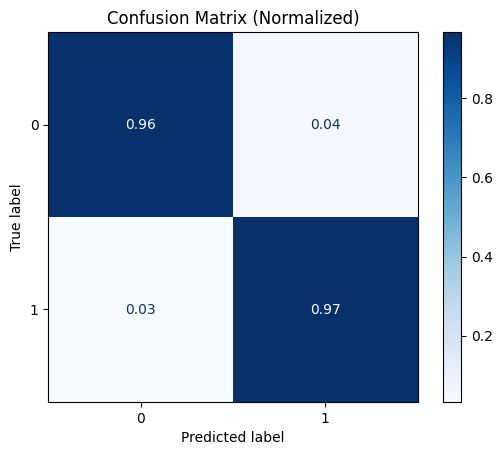

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import os

os.makedirs("plots", exist_ok=True)

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices)

disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Normal)')
plt.savefig(os.path.join('plots', 'confusion_matrix_normal.png'))
plt.show()

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=test_generator.class_indices)
disp.plot(cmap=plt.cm.Blues, values_format=".2f")
plt.title('Confusion Matrix (Normalized)')
plt.savefig(os.path.join('plots', 'confusion_matrix_normalized.png'))
plt.show()

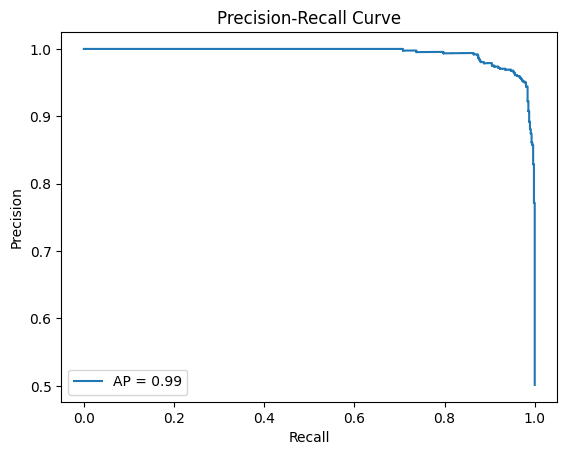

In [22]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
average_precision = average_precision_score(y_true, y_pred)

plt.figure()
plt.step(recall, precision, where='post', label=f'AP = {average_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.savefig(os.path.join('plots', 'precision_recall_curve.png'))
plt.show()

In [23]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys())
print(report)

with open(os.path.join('plots', 'classification_report.txt'), 'w') as f:
    f.write(report)

              precision    recall  f1-score   support

           0       0.97      0.96      0.96       565
           1       0.96      0.97      0.96       568

    accuracy                           0.96      1133
   macro avg       0.96      0.96      0.96      1133
weighted avg       0.96      0.96      0.96      1133



1/1 [==============================] - 1s 1s/step


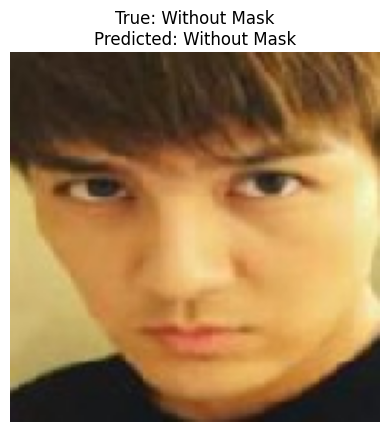

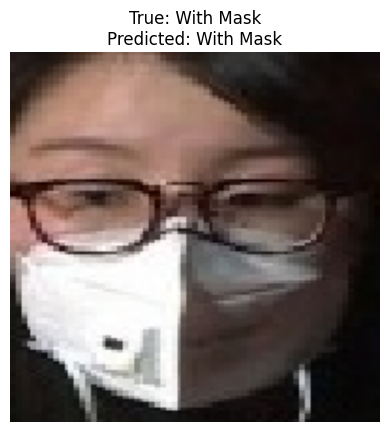

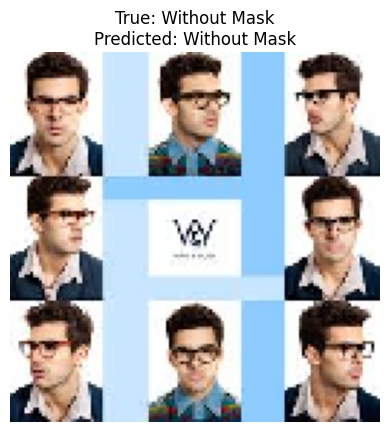

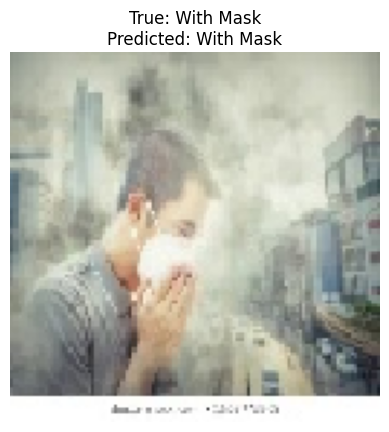

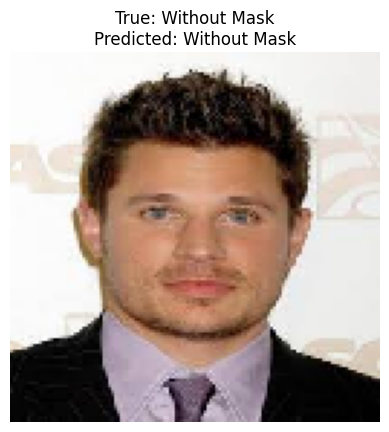

In [23]:
import matplotlib.pyplot as plt

x_test, y_test = next(test_generator)
y_pred_sample = model.predict(x_test)

for i in range(5):
    plt.imshow(x_test[i])
    plt.title(f"True: {'With Mask' if y_test[i] == 0 else 'Without Mask'}\n"
              f"Predicted: {'With Mask' if y_pred_sample[i] < 0.5 else 'Without Mask'}")
    plt.axis('off')
    plt.savefig(os.path.join('plots', f'sample_prediction_{i + 1}.png'))
    plt.show()
